In [1]:
import pandas as pd
import  duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

%load_ext autoreload
from duckdb_flow.etl import preprocess_data, get_processed_files
from duckdb_flow.create_database import create_database


The autoreload module is not an IPython extension.


In [2]:
STAGING_PATH = "./data"
DATABASE_PATH = "./database/DDBB_duckdb.duckdb"

In [3]:
create_database()

'Database Created'

In [4]:
processed_files = get_processed_files()
movies_df, directing_data, writing_data  = preprocess_data(processed_files)

Created  directing_df  dataframe.
Appending:  963  rows...
Appending:  993  rows...
Appending:  951  rows...
Appending:  1049  rows...
Appending:  974  rows...
Appending:  1001  rows...
Appending:  1035  rows...
Appending:  993  rows...
Created  writing_df  dataframe.


In [5]:
STAGING_PATH = "./data"
DATABASE_PATH = "./database/DDBB_duckdb.duckdb"

## EDA

### Movies

In [7]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
movies = con.execute('''select * from movies''').fetch_df()
movies.shape
con.close()

In [8]:
movies.head()

,movie_id,primary_title,original_title,start_year,runtime_min,num_votes,label,subset,audit_time
0,tt0010600,The Doll,Die Puppe,1919,66,1898,True,train,2024-03-07 23:56:59.534
1,tt0011841,Way Down East,Way Down East,1920,145,5376,True,train,2024-03-07 23:56:59.534
2,tt0012494,Déstiny,Der müde Tod,1921,97,5842,True,train,2024-03-07 23:56:59.534
3,tt0015163,The Navigator,The Navigator,1924,59,9652,True,train,2024-03-07 23:56:59.534
4,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,93,17887,True,train,2024-03-07 23:56:59.534


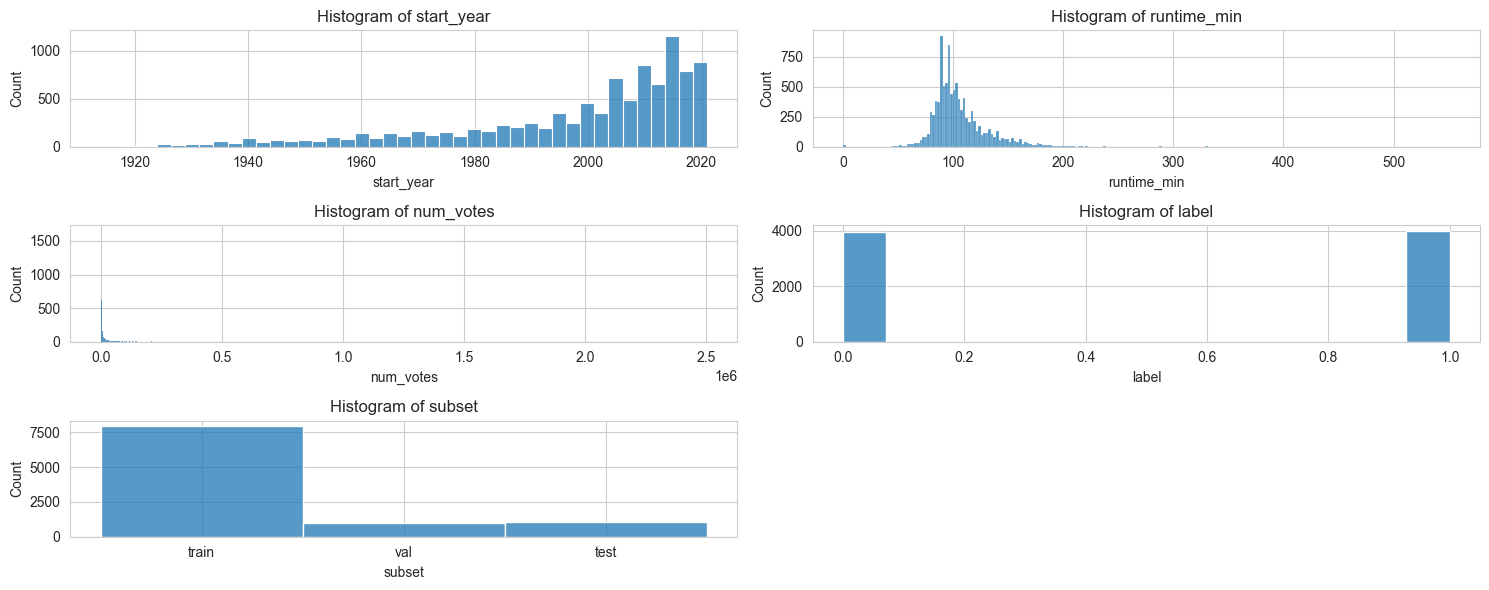

In [12]:
num_cols = len(['start_year', 'runtime_min', 'num_votes', 'label', 'subset'])
num_rows = (num_cols + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6))

axes = axes.flatten()

for i, column in enumerate(['start_year', 'runtime_min', 'num_votes', 'label', 'subset']):
    if column == 'num_votes':
        sns.histplot(movies[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')
    else:
        sns.histplot(movies[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

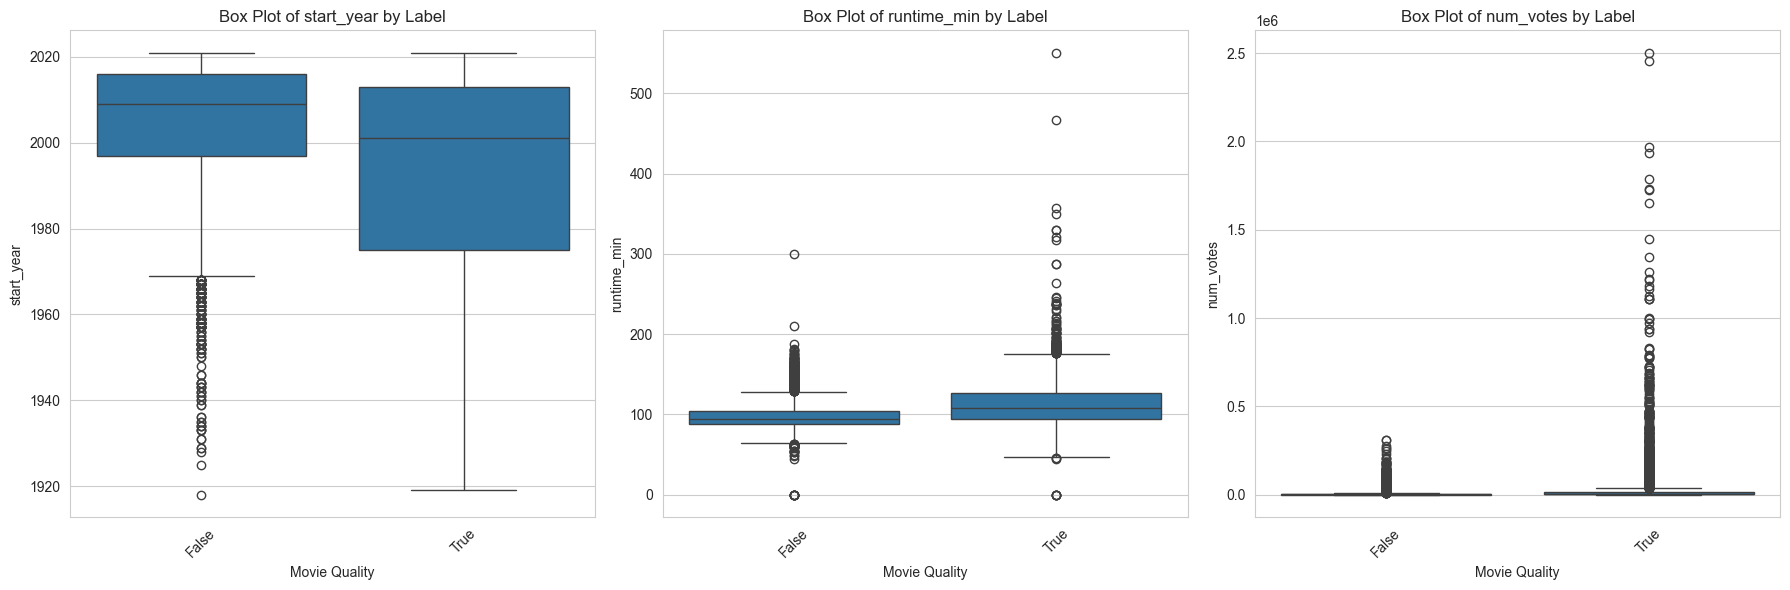

In [10]:

continuous_variables = ['start_year', 'runtime_min', 'num_votes']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, variable in enumerate(continuous_variables):
    sns.boxplot(x='label', y=variable, data=movies, ax=axes[i])
    axes[i].set_title(f'Box Plot of {variable} by Label')
    axes[i].set_xlabel('Movie Quality')
    axes[i].set_ylabel(variable)
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

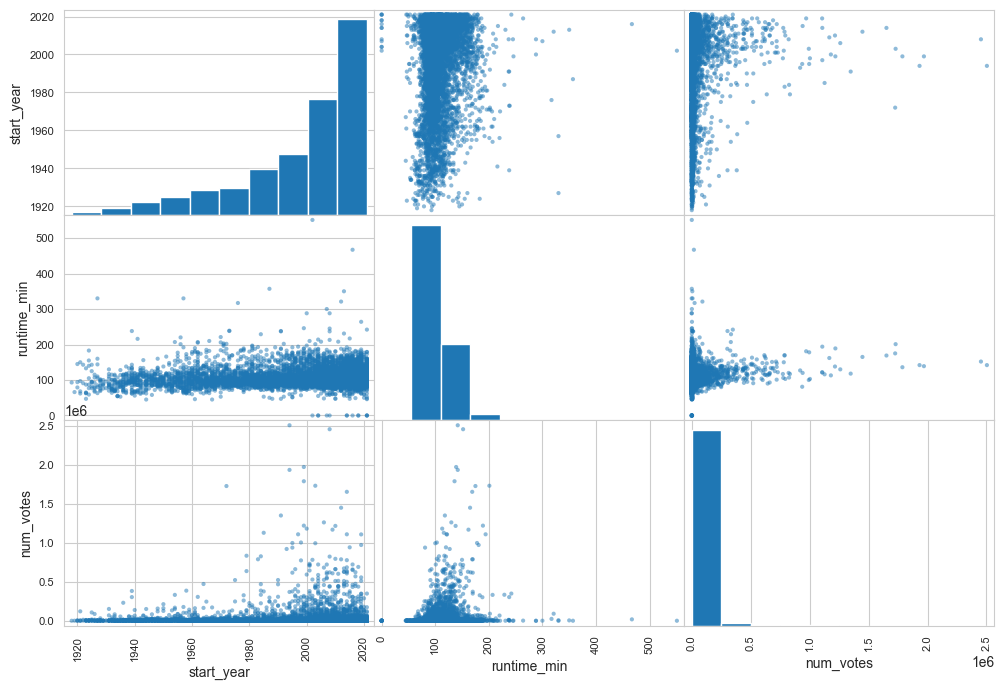

In [14]:
from pandas.plotting import scatter_matrix

scatter_matrix(movies[movies["subset"]=="train"][['start_year', 'runtime_min', 'num_votes', 'label']], figsize=(12, 8))
plt.show()

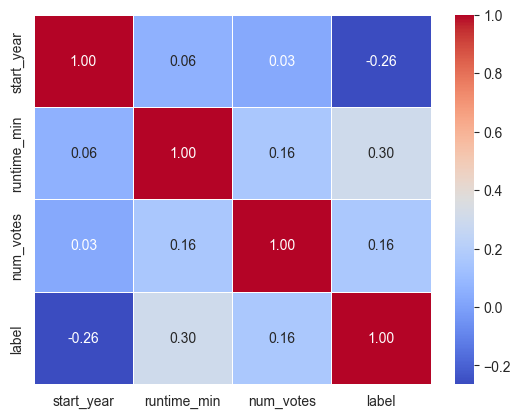

In [8]:
sns.heatmap(movies[movies["subset"]=="train"][['start_year', 'runtime_min', 'num_votes', 'label']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

### Directors

### Writers